# Análisis Exploratorio

En esta sección, realizaremos un análisis inicial del conjunto de datos **UrbanSound8K**. Este análisis nos permitirá comprender la estructura y el contenido del banco de datos descargado. Antes de continuar, es importante asegurarnos de que se haya ejecutado correctamente el script **setup.sh** y que la carpeta ***UrbanSound8K*** esté ubicada dentro de la carpeta `data`.

El conjunto de datos contiene información sobre archivos de audio clasificados en diferentes categorías de sonidos urbanos. A continuación, exploraremos las características principales del dataframe, incluyendo las columnas disponibles, el número de registros, los tipos de datos y las estadísticas descriptivas.


In [1]:
# Configuración de matplotlib para notebooks
%matplotlib inline

# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento de audio
import librosa
from IPython.display import Audio

# Manejo de archivos y sistema operativo
import os

# Machine Learning y Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


2025-05-16 16:47:32.528301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 16:47:32.829241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747435652.903757   19072 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747435652.927375   19072 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747435653.132717   19072 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Check GPU availability
# This code aims to verify if there are devices available for processing,
print("Available devices:")
print(tf.config.list_physical_devices())

Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Load the data
# Define the base path where the audio files and metadata are located
FILES_PATH = "./data/UrbanSound8K"  # Path to the audio files

# Read the CSV file containing the metadata of the UrbanSound8K dataset
# This file includes information such as file name, sound class, duration, etc.
dataframe_audios = pd.read_csv(
    f"{FILES_PATH}/metadata/UrbanSound8K.csv"
)  # UrbanSound8K provides this file upon downloading the dataset

# Display the first few rows of the DataFrame to inspect its content
dataframe_audios.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
# Add a new column "audio_path" to the dataframe
# This column contains the full file path for each audio file in the dataset.
# The path is constructed using the base path (FILES_PATH), the fold number, and the slice file name.
dataframe_audios["audio_path"] = dataframe_audios.apply(
    lambda row: os.path.join(
        FILES_PATH, "audio", f"fold{row['fold']}", row["slice_file_name"]
    ),
    axis=1,
)


# Display the first few rows of the updated dataframe to verify the new column
dataframe_audios

,slice_file_name,fsID,start,end,salience,fold,classID,class,audio_path
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,./data/UrbanSound8K/audio/fold5/100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-117...
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-121...
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-126...
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-137...
...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-2-0.wav
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-3-0.wav
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-4-0.wav
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-5-0.wav


## Analisis del dataframe

In [5]:
# Display basic information about the dataframe
dataframe_audios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   audio_path       8732 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 614.1+ KB


In [6]:
# Generate descriptive statistics for the dataframe
dataframe_audios.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [7]:
# Display descriptive statistics for the dataframe
# This helps to understand the distribution, central tendency, and spread of the data,
# as well as unique values and frequency for categorical columns.
dataframe_audios.describe(include="all")

,slice_file_name,fsID,start,end,salience,fold,classID,class,audio_path
count,8732,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732,8732
unique,8732,NaN,NaN,NaN,NaN,NaN,NaN,10,8732
top,99812-1-6-0.wav,NaN,NaN,NaN,NaN,NaN,NaN,dog_bark,./data/UrbanSound8K/audio/fold7/99812-1-6-0.wav
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,1000,1
mean,NaN,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877,NaN,NaN
std,NaN,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544,NaN,NaN
min,NaN,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000,NaN,NaN
25%,NaN,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000,NaN,NaN
50%,NaN,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000,NaN,NaN
75%,NaN,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000,NaN,NaN


In [8]:
# Display unique classes and their counts
# This provides an overview of the different sound classes present in the dataset.
print("Categorías únicas:", dataframe_audios["class"].unique())

# The `value_counts()` method counts the occurrences of each category in the "class" column.
# This helps to understand the distribution of samples across different sound classes.
print("Conteo por clase:\n", dataframe_audios["class"].value_counts())

Categorías únicas: ['dog_bark' 'children_playing' 'car_horn' 'air_conditioner' 'street_music'
 'gun_shot' 'siren' 'engine_idling' 'jackhammer' 'drilling']
Conteo por clase:
 class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


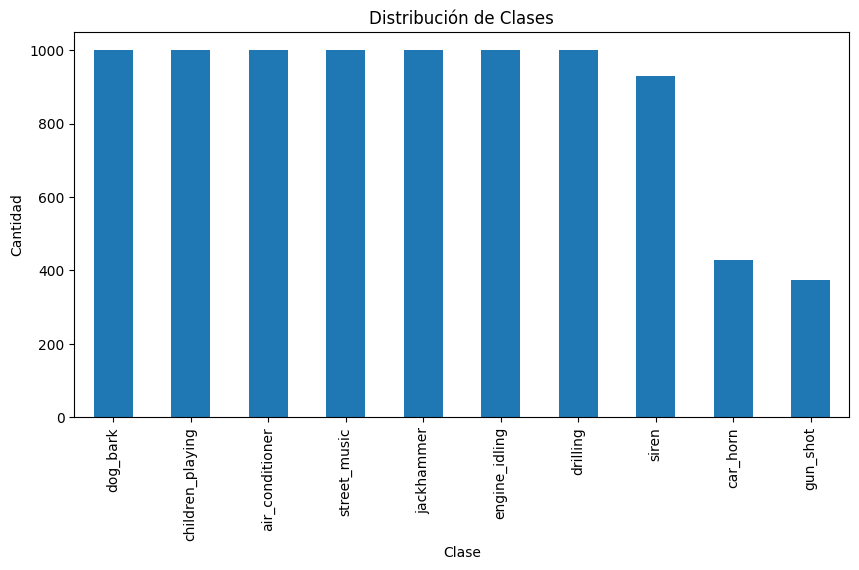

In [9]:
# Visualize the distribution of classes in the dataset
# This provides an overview of how many samples belong to each sound class.

dataframe_audios["class"].value_counts().plot(kind="bar", figsize=(10, 5))

# Add a title and labels to the plot for better understanding
plt.title("Distribución de Clases")  # Title of the plot
plt.ylabel("Cantidad")  # Label for the y-axis
plt.xlabel("Clase")  # Label for the x-axis

# Display the plot
plt.show()

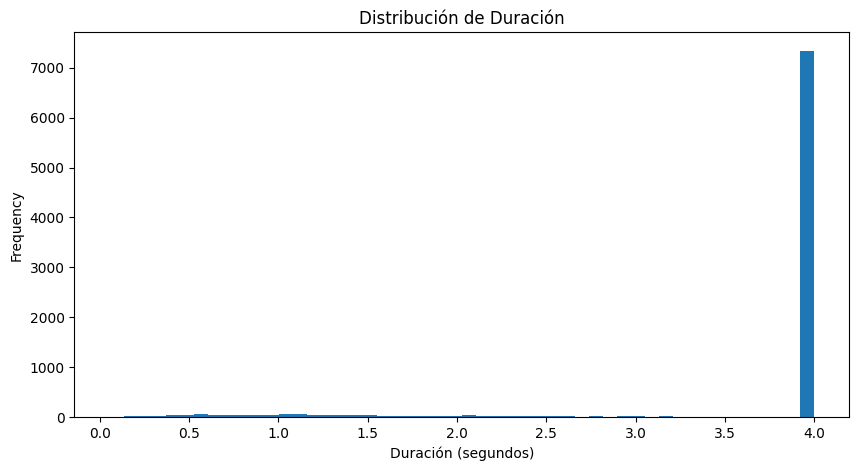

In [10]:
# Calculate the duration of each audio clip
# which represent the start and end times of each audio clip in seconds.
dataframe_audios["duration"] = dataframe_audios["end"] - dataframe_audios["start"]

# Plot the distribution of audio durations
# The x-axis represents the duration in seconds, and the y-axis represents the frequency of clips.
dataframe_audios["duration"].plot(kind="hist", bins=50, figsize=(10, 5))

# Add a title and labels to the plot for better understanding
plt.title("Distribución de Duración")  # Title of the plot
plt.xlabel("Duración (segundos)")  # Label for the x-axis

# Display the plot
plt.show()

### Probando la carga y visualización de un audio

En esta sección, cargaremos un archivo de audio del conjunto de datos y lo visualizaremos. Para ello, utilizaremos las herramientas de procesamiento de audio disponibles en la biblioteca `librosa`. Además, acotaremos la visualización del audio según los tiempos de inicio y fin especificados en el dataframe `dataframe_audios`. Esto nos permitirá analizar de manera más detallada las características del audio seleccionado.

In [11]:
# Load and play an audio file to ensure the audio data is correctly loaded and audible.
# This step is crucial for verifying the integrity of the audio files in the dataset.

# Select an audio file (e.g., the first row)
audio_file_path = dataframe_audios["audio_path"].iloc[0]  # Adjust the path if necessary
audio_data, sample_rate = librosa.load(audio_file_path, sr=None)  # Load audio

# Play the audio
Audio(data=audio_data, rate=sample_rate)

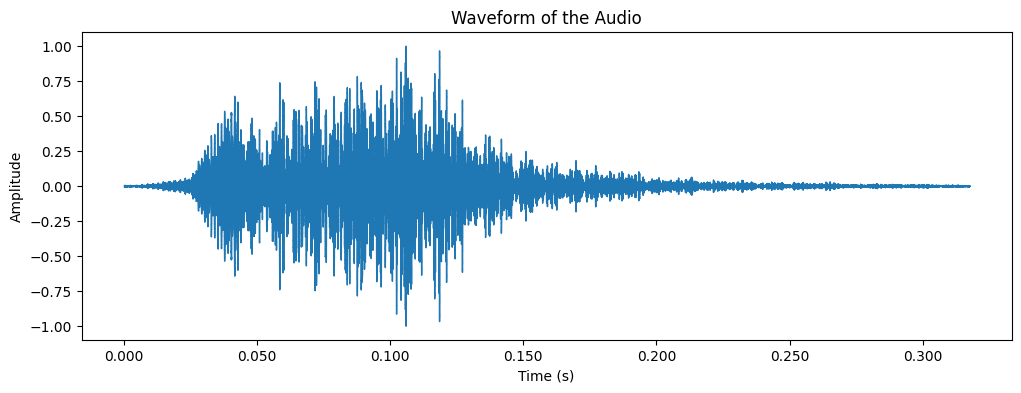

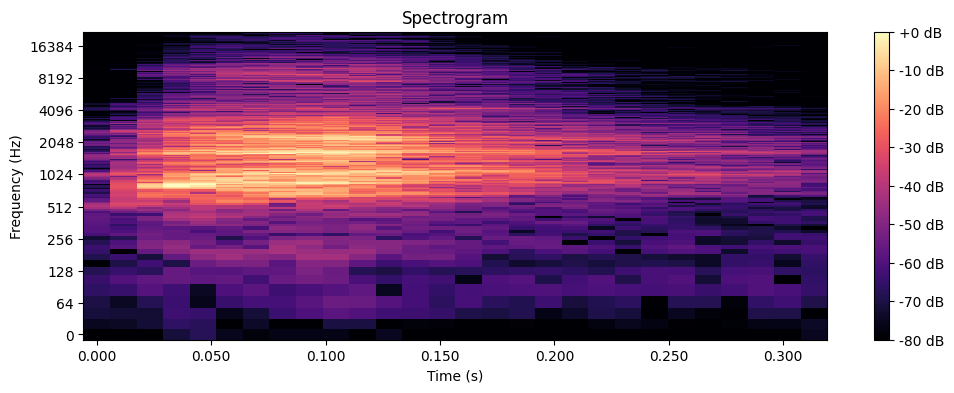

In [12]:
# Visualize the waveform and spectrogram of the audio file
# This step helps us understand the time-domain and frequency-domain characteristics of the audio data.

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.title("Waveform of the Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Plot the spectrogram
# The spectrogram provides a visual representation of the frequency content of the audio over time.
spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data)), ref=np.max)
plt.figure(figsize=(12, 4))
librosa.display.specshow(spectrogram, sr=sample_rate, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

# Preparacion de los datos


In [13]:
dataframe_audios

,slice_file_name,fsID,start,end,salience,fold,classID,class,audio_path,duration
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,./data/UrbanSound8K/audio/fold5/100032-3-0-0.wav,0.317551
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-117...,4.000000
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-121...,4.000000
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-126...,4.000000
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,./data/UrbanSound8K/audio/fold5/100263-2-0-137...,4.000000
...,...,...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-2-0.wav,4.000000
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-3-0.wav,2.142545
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-4-0.wav,3.505983
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn,./data/UrbanSound8K/audio/fold7/99812-1-5-0.wav,2.532098


In [14]:
# Split the dataset into training and testing sets in a stratified manner
# Features: paths to audio files
audio_file_paths = dataframe_audios["audio_path"]

# Perform the stratified split
train_audio_paths, test_audio_paths, train_labels, test_labels = train_test_split(
    audio_file_paths,
    dataframe_audios["classID"],
    test_size=0.3,
    stratify=dataframe_audios["classID"],
    random_state=8,
)


## Extraer las características de los audios

En este módulo, nos enfocaremos en la extracción de características relevantes de los archivos de audio. Específicamente, utilizaremos los coeficientes cepstrales de frecuencia de Mel (MFCC) para representar cada archivo de audio como un tensor numérico. Los MFCC son ampliamente utilizados en el procesamiento de señales de audio, ya que capturan información importante sobre el contenido espectral del sonido, lo que los hace ideales para tareas de clasificación y reconocimiento de audio.

El objetivo es implementar funciones que permitan calcular los MFCC de cada archivo de audio y garantizar que todos los tensores tengan una longitud fija, aplicando padding o recorte según sea necesario. Esto asegurará que los datos estén en un formato consistente para ser utilizados en modelos de aprendizaje profundo.

### Normalizar los MFCCs

En este paso, normalizamos las características MFCC para garantizar que todos los valores estén en una escala similar, lo que ayuda a mejorar el rendimiento y la estabilidad del modelo durante el entrenamiento.

### Agregar características delta

Las características delta representan la tasa de cambio de los MFCCs a lo largo del tiempo. Agregar estas características puede proporcionar información temporal adicional, lo que podría mejorar la capacidad del modelo para clasificar señales de audio.

In [15]:
def extract_mfcc(audio_file_path, num_mfcc=13, max_padding_length=174, sr=22050):
    """
    Extracts MFCCs with delta and delta-delta features.
    Returns array of shape (39, max_padding_length) ready for CNN input.
    """
    # 1. Load audio with fixed sample rate
    audio_signal, _ = librosa.load(audio_file_path, sr=sr)

    # 2. Extract base MFCCs
    mfcc_features = librosa.feature.mfcc(
        y=audio_signal,
        sr=sr,
        n_mfcc=num_mfcc,
        n_fft=min(2048, len(audio_signal)),
        hop_length=512,
        fmax=sr / 2,
    )

    # 3. Normalize per coefficient
    mfcc_features = librosa.util.normalize(mfcc_features)

    # 4. Pad/truncate to fixed length
    if mfcc_features.shape[1] < max_padding_length:
        mfcc_features = np.pad(
            mfcc_features,
            ((0, 0), (0, max_padding_length - mfcc_features.shape[1])),
            mode="constant",
        )
    else:
        mfcc_features = mfcc_features[:, :max_padding_length]

    # 5. Add delta features
    delta_mfcc = librosa.feature.delta(mfcc_features)
    delta2_mfcc = librosa.feature.delta(mfcc_features, order=2)

    # Stack features vertically (39, 174)
    return np.vstack([mfcc_features, delta_mfcc, delta2_mfcc])


# Modelo CNN

En este módulo, implementaremos una red neuronal convolucional (CNN) para procesar los coeficientes cepstrales de frecuencia de Mel (MFCCs) extraídos de los archivos de audio. Las CNN son especialmente efectivas para tareas de clasificación de datos estructurados espacialmente, como imágenes o, en este caso, representaciones espectrales de audio.

La arquitectura de la red incluye capas convolucionales para extraer características relevantes, capas de normalización para estabilizar el entrenamiento, y capas densas con regularización para evitar el sobreajuste. Finalmente, la red utiliza una capa de salida con activación softmax para clasificar los audios en las diferentes categorías de sonidos urbanos.


In [16]:
# Number of output classes (unique sound categories)
num_classes = dataframe_audios["classID"].nunique()
num_classes

10

In [18]:
import json

class_mapping = dict(
    zip(dataframe_audios["class"].unique(), dataframe_audios["classID"].unique())
)
class_mapping

# Save class_mapping to a JSON file for server-side loading
# Convert all values to native Python int for JSON serialization
class_mapping_json = {k: int(v) for k, v in class_mapping.items()}
with open("./model/class_mapping.json", "w") as f:
    json.dump(class_mapping_json, f)

In [19]:
# Define the input shape for the CNN: (time_steps, features, channels)
input_shape = (174, 39, 1)

# Build the CNN model using Keras Sequential API
model = models.Sequential(
    [
        # Input layer specifying the shape of the input data
        layers.Input(shape=input_shape),
        # --- Convolutional Block 1 ---
        # Extracts low-level features from the input MFCCs
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),  # Normalizes activations for stable training
        layers.MaxPooling2D((2, 2)),  # Reduces spatial dimensions (downsampling)
        layers.Dropout(0.3),  # Prevents overfitting
        # --- Convolutional Block 2 ---
        # Learns more complex features
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        # --- Convolutional Block 3 ---
        # Captures even higher-level patterns
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        # --- Classifier Head ---
        # Flattens the feature maps to a 1D vector for classification
        layers.Flatten(),
        # Dense layer with L2 regularization to reduce overfitting
        layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),  # Stronger dropout for the dense layer
        # Output layer with softmax activation for multi-class classification
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Compile the model with Adam optimizer and sparse categorical crossentropy loss
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Print the model summary to visualize the architecture
model.summary()


I0000 00:00:1747435760.863754   19072 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 174, 39, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 174, 39, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 87, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 87, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 19, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 87, 19, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 9, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 43, 9, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 43, 9, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 4, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,752,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,849,930 (10.87 MB)

 Trainable params: 2,848,970 (10.87 MB)

 Non-trainable params: 960 (3.75 KB)

**ENTRENAMIENTO DEL MODELO**

En esta etapa, procederemos a entrenar el modelo de clasificación de audio utilizando los coeficientes cepstrales de frecuencia de Mel (MFCC) previamente extraídos. Este proceso puede tomar un tiempo considerable dependiendo de la capacidad de procesamiento de la GPU disponible y del tamaño del conjunto de datos. Asegúrate de contar con los recursos necesarios antes de iniciar el entrenamiento.

In [20]:
# 1. Extract MFCCs (already correct)
X_train = np.array(
    [extract_mfcc(path) for path in train_audio_paths]
)  # Shape: (6112, 39, 174)
X_test = np.array(
    [extract_mfcc(path) for path in test_audio_paths]
)  # Shape: (2620, 39, 174)

# 2. Transpose to get (samples, 174, 39) - TIME x FEATURES
X_train = np.transpose(X_train, (0, 2, 1))  # New shape: (6112, 174, 39)
X_test = np.transpose(X_test, (0, 2, 1))  # New shape: (2620, 174, 39)

# 3. Add channel dimension (required by Conv2D)
X_train = X_train[..., np.newaxis]  # Final shape: (6112, 174, 39, 1)
X_test = X_test[..., np.newaxis]  # Final shape: (2620, 174, 39, 1)

# 4. Labels (already correct)
y_train = np.array(train_labels)  # Shape: (6112,)
y_test = np.array(test_labels)  # Shape: (2620,)


In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6112, 174, 39, 1)
y_train shape: (6112,)
X_test shape: (2620, 174, 39, 1)
y_test shape: (2620,)


In [22]:
# Callbacks for training
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping  # type: ignore

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
]

# Training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,  # after training the previous model, i saw it established a plateau at 70 epochs
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/100


I0000 00:00:1747436135.530304   19343 service.cc:152] XLA service 0x7f1dec0073a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747436135.530318   19343 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-16 16:55:35.602094: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747436135.836970   19343 cuda_dnn.cc:529] Loaded cuDNN version 90800


 22/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1776 - loss: 3.5793

I0000 00:00:1747436139.525266   19343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3101 - loss: 2.8068 - val_accuracy: 0.0248 - val_loss: 8.1838 - learning_rate: 0.0010
Epoch 2/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5486 - loss: 1.8383 - val_accuracy: 0.1168 - val_loss: 11.8314 - learning_rate: 0.0010
Epoch 3/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6342 - loss: 1.5518 - val_accuracy: 0.1863 - val_loss: 6.0945 - learning_rate: 0.0010
Epoch 4/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6839 - loss: 1.3657 - val_accuracy: 0.2328 - val_loss: 5.3402 - learning_rate: 0.0010
Epoch 5/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7423 - loss: 1.2046 - val_accuracy: 0.1252 - val_loss: 53.0925 - learning_rate: 0.0010
Epoch 6/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7594 - loss: 1.1713 - val_accuracy: 0.0996 - val_loss: 46.8688 - learning_rate: 0.0010
Epoch 7/100
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7808 - loss: 1.0621 - v

In [23]:
# Save the trained model to a file
model.save("./model/audio_classification_model.keras")

In [24]:
# Load the saved audio classification model
# Why we do this:
# - To reuse the trained model for predictions or further training.
# - To validate that the saved model can be successfully restored.
model = tf.keras.models.load_model("./model/audio_classification_model.keras")

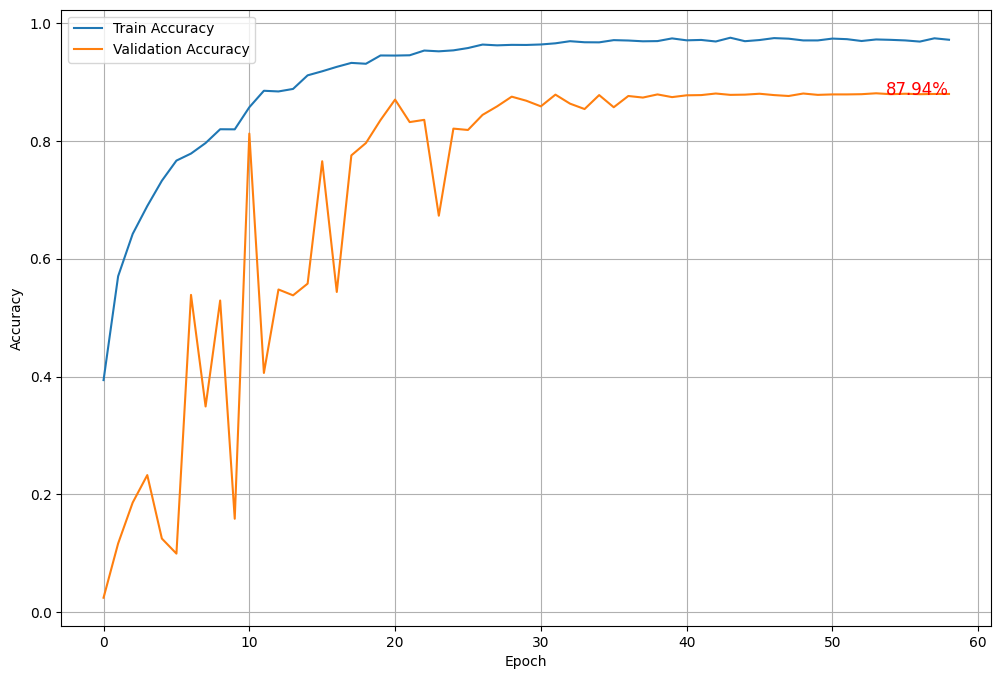

In [25]:
# curva de aprendizaje
plt.figure(figsize=(12, 8))  # Aumentar el tamaño de la figura
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")

# Agregar texto con el accuracy final
final_val_accuracy = (
    history.history["val_accuracy"][-1] * 100
)  # Último valor de val_accuracy
plt.text(
    len(history.history["val_accuracy"]) - 1,  # Última época
    history.history["val_accuracy"][-10],  # Valor de val_accuracy
    f"{final_val_accuracy:.2f}%",  # Texto con el porcentaje
    fontsize=12,
    color="red",
    ha="right",
)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)  # Añadir una cuadrícula para mayor precisión
plt.show()

In [26]:
# Evaluate the model on the test dataset
# Why we do this:
# - To measure the model's performance on unseen data.
# - To calculate the test accuracy and loss for evaluation purposes.
test_loss, test_accuracy = model.evaluate(
    X_test,  # Changed from X_test_mfcc_features to X_test
    y_test,  # Changed from test_labels to y_test (numpy array version)
)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8870 - loss: 0.5672
Test Accuracy: 88.02%


In [27]:
# Generate a confusion matrix to analyze model predictions
# Why we do this:
# - To visualize the performance of the model in terms of correctly and incorrectly classified samples.
# - To identify patterns of misclassification for further improvements.


# Get predictions
predicted_labels = np.argmax(
    model.predict(X_test),  # Changed from X_test_mfcc_features to X_test
    axis=1,
)

# Generate confusion matrix
confusion_matrix_result = confusion_matrix(
    y_test, predicted_labels
)  # Changed from test_labels to y_test

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


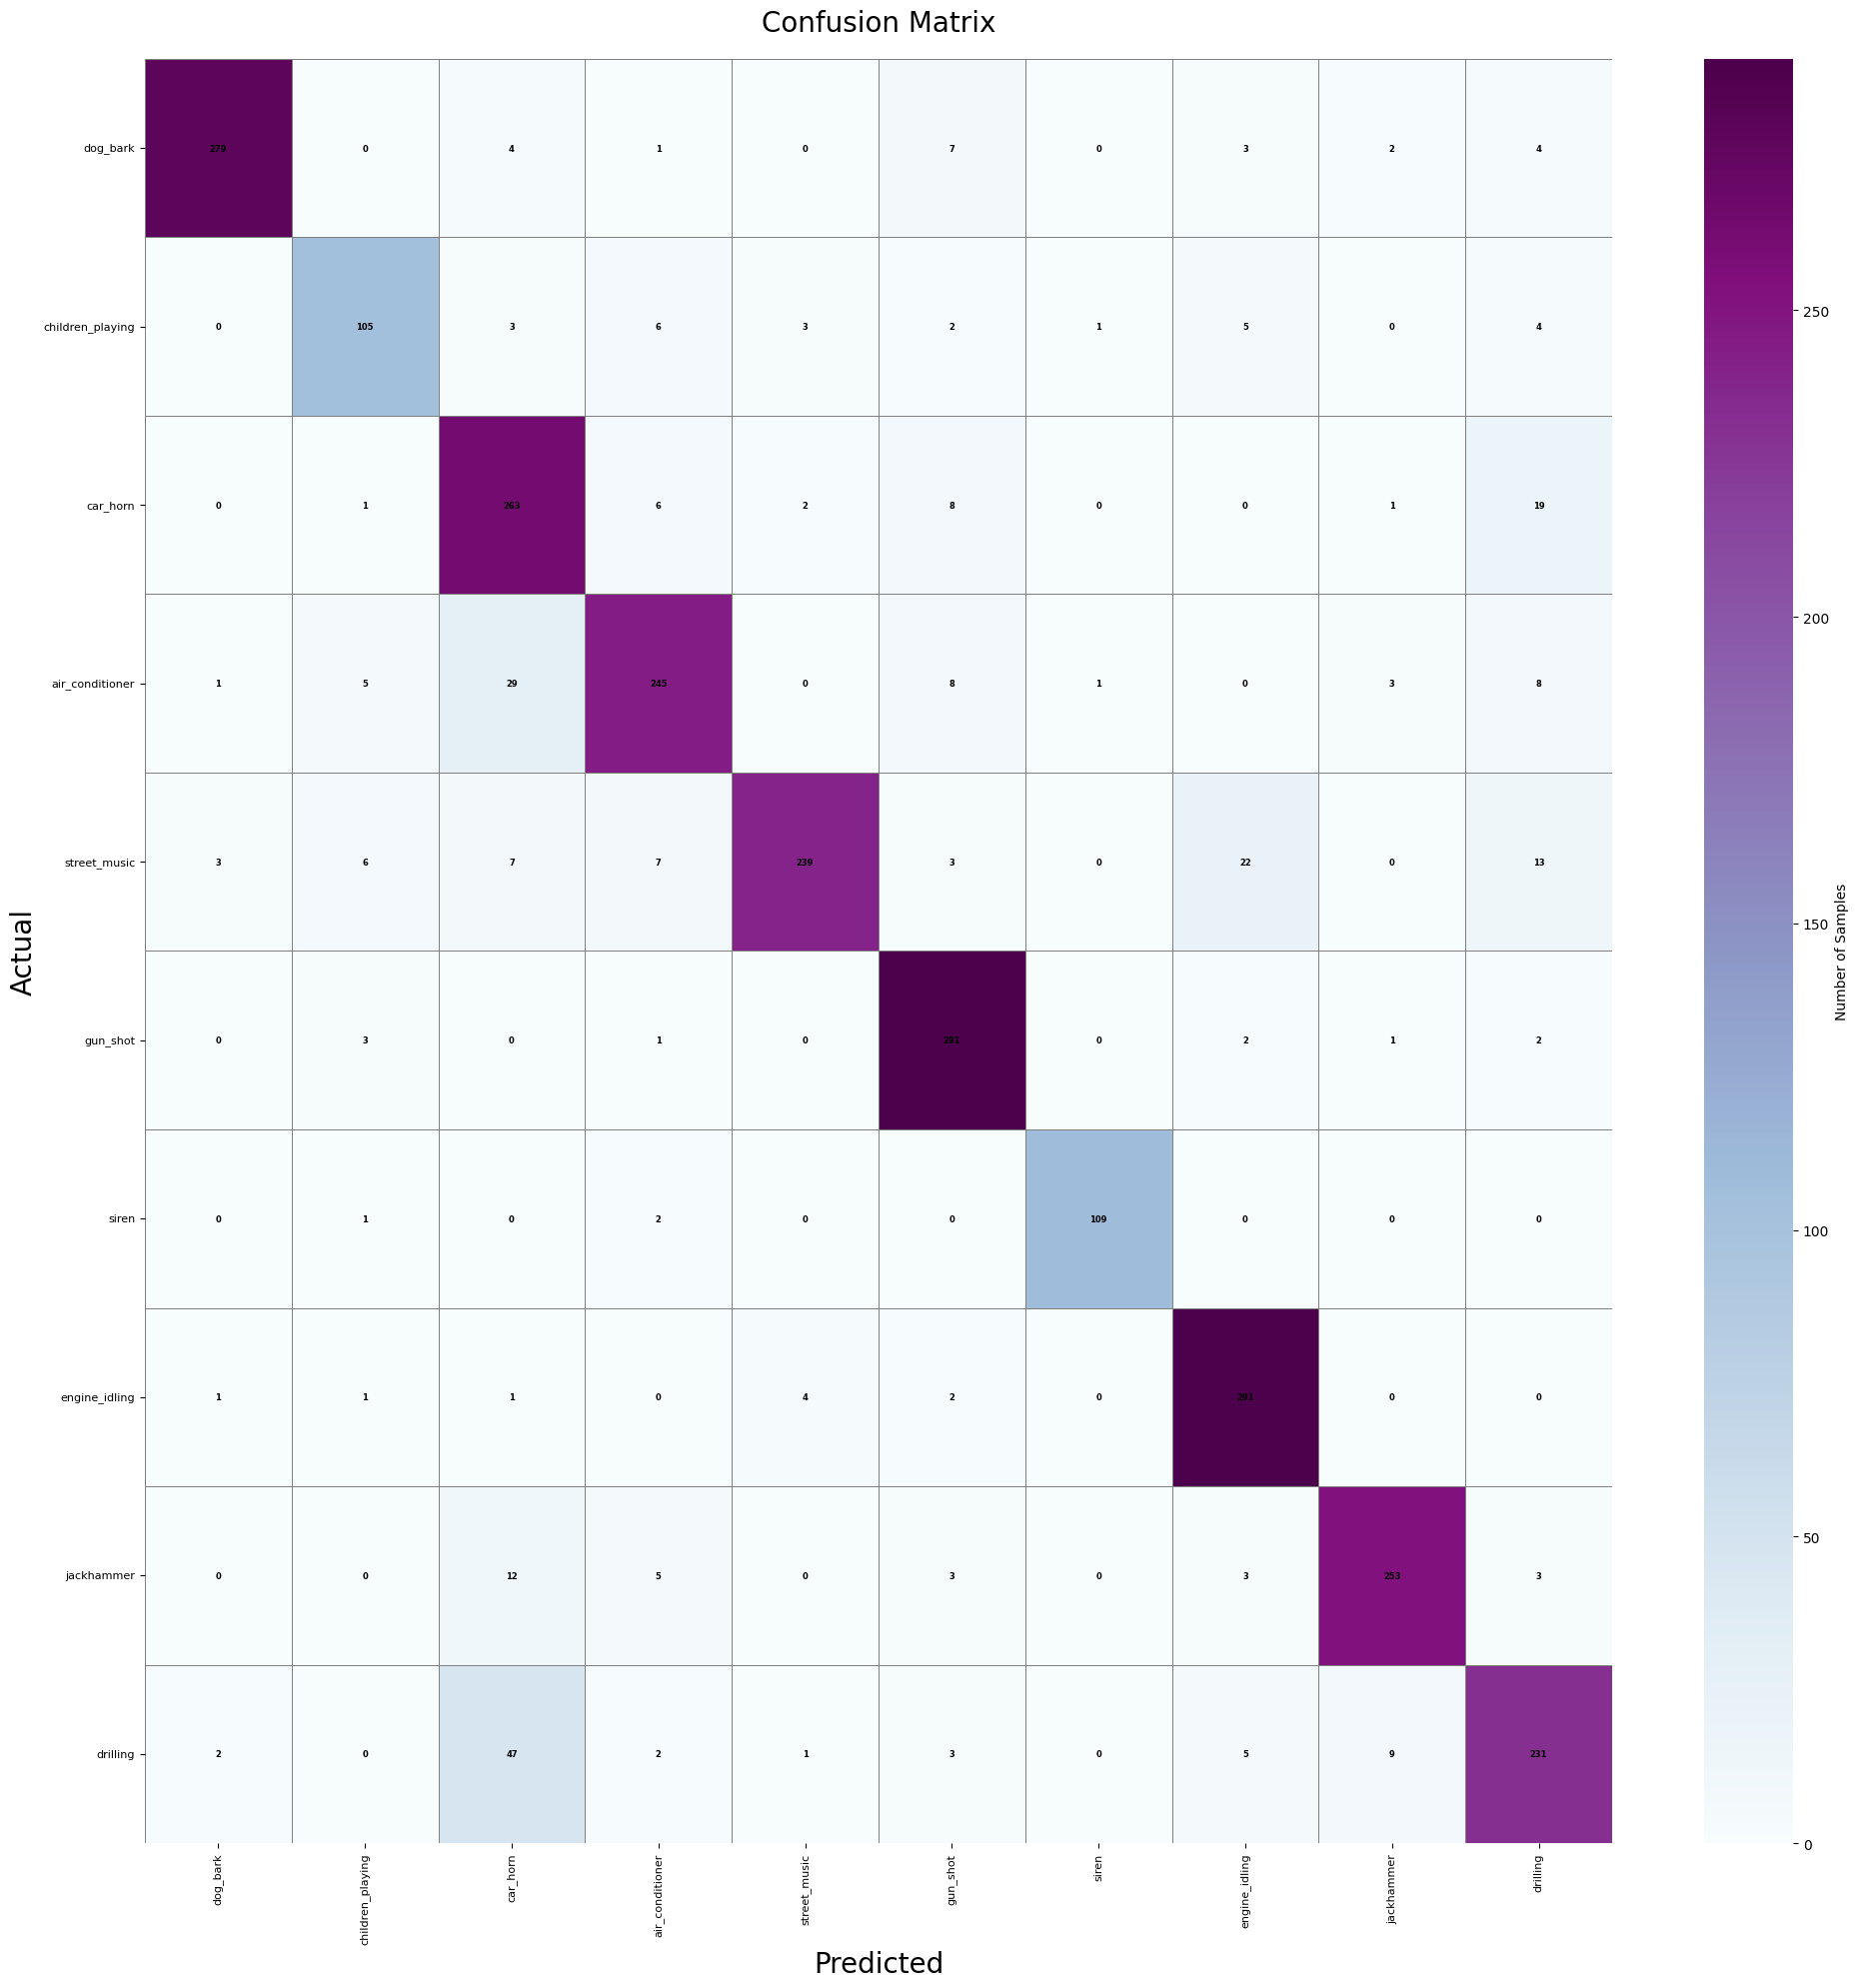

In [28]:
# Crear el heatmap
plt.figure(figsize=(20, 20))  # Tamaño más grande para que entren bien las etiquetas

# Ensure class names are extracted from the label encoder
# Create the heatmap
ax = sns.heatmap(
    confusion_matrix_result,
    annot=True,
    fmt="d",
    cmap="BuPu",  # Cambiado a "viridis"
    xticklabels=class_mapping.keys(),
    yticklabels=class_mapping.keys(),
    linewidths=0.5,
    linecolor="grey",
    cbar_kws={"label": "Number of Samples"},
    annot_kws={"size": 6, "color": "black", "weight": "bold"},  # Cambiado a negro
)

# Ajustar los textos
ax.set_title("Confusion Matrix", fontsize=20, pad=20)
ax.set_xlabel("Predicted", fontsize=20)
ax.set_ylabel("Actual", fontsize=20)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

# Fondo del eje
ax.set_facecolor("black")

# Layout para evitar recortes
plt.tight_layout()
plt.show()


In [29]:
class_mapping

{'dog_bark': np.int64(3),
 'children_playing': np.int64(2),
 'car_horn': np.int64(1),
 'air_conditioner': np.int64(0),
 'street_music': np.int64(9),
 'gun_shot': np.int64(6),
 'siren': np.int64(8),
 'engine_idling': np.int64(5),
 'jackhammer': np.int64(7),
 'drilling': np.int64(4)}

In [30]:
def predict_audio(audio_path, model, class_mapping):
    """
    Predicts the class of an audio file using your trained model and original extract_mfcc.

    Args:
        audio_path (str): Path to the audio file (e.g., "test.wav")
        model (keras.Model): Trained CNN model
        class_mapping (dict): Class dictionary (e.g., {'dog_bark': 0})

    Returns:
        tuple: (predicted_class, confidence)
    """
    # 1. Extract MFCCs using YOUR original function
    mfcc_features = extract_mfcc(audio_path)  # Shape: (39, 174)

    # 2. Transpose and reshape TO MATCH TRAINING
    mfcc_features = mfcc_features.T  # Shape: (174, 39)
    mfcc_features = mfcc_features[np.newaxis, ..., np.newaxis]  # Shape: (1, 174, 39, 1)

    # 3. Predict
    predictions = model.predict(mfcc_features, verbose=0)[0]
    predicted_class_idx = np.argmax(predictions)
    confidence = float(predictions[predicted_class_idx])

    # 4. Map to class name
    id_to_class = {v: k for k, v in class_mapping.items()}

    return id_to_class[predicted_class_idx], confidence


In [31]:
predict_audio(
    audio_path=test_audio_paths.iloc[0],  # Path to the audio file
    model=model,  # Loaded model
    class_mapping=class_mapping,
)


('siren', 0.9996250867843628)

In [32]:
# Search in dataframe_audios for the row whose audio_path matches test_audio_paths.iloc[0]
row = dataframe_audios[dataframe_audios["audio_path"] == test_audio_paths.iloc[0]]
row

,slice_file_name,fsID,start,end,salience,fold,classID,class,audio_path,duration
2492,157867-8-0-20.wav,157867,10.0,14.0,1,1,8,siren,./data/UrbanSound8K/audio/fold1/157867-8-0-20.wav,4.0


In [33]:
import random


def muestra_predicciones(model, test_audio_paths, test_labels, class_mapping, n=14):
    """
    Randomly selects n audios from the test set and shows the prediction vs the real class.
    Adds a column indicating if the prediction was correct.
    """
    id_to_class = {v: k for k, v in class_mapping.items()}
    indices = random.sample(range(len(test_audio_paths)), n)
    resultados = []

    for idx in indices:
        audio_path = test_audio_paths.iloc[idx]
        real_id = test_labels.iloc[idx]
        real_class = id_to_class[real_id]
        pred_class, confianza = predict_audio(audio_path, model, class_mapping)
        acierto = pred_class == real_class
        resultados.append(
            {
                "audio_path": audio_path,
                "real": real_class,
                "predicho": pred_class,
                "confianza": confianza,
                "acierto": acierto,
            }
        )

    return pd.DataFrame(resultados)


# Example usage:
muestra_predicciones(model, test_audio_paths, test_labels, class_mapping)


,audio_path,real,predicho,confianza,acierto
0,./data/UrbanSound8K/audio/fold5/148841-6-2-0.wav,gun_shot,gun_shot,0.999634,True
1,./data/UrbanSound8K/audio/fold10/180127-4-0-8.wav,drilling,drilling,0.999133,True
2,./data/UrbanSound8K/audio/fold2/113201-5-0-7.wav,engine_idling,engine_idling,0.999092,True
3,./data/UrbanSound8K/audio/fold4/115415-9-0-5.wav,street_music,street_music,0.999955,True
4,./data/UrbanSound8K/audio/fold7/50629-4-0-1.wav,drilling,drilling,0.995867,True
5,./data/UrbanSound8K/audio/fold7/146845-0-0-17.wav,air_conditioner,air_conditioner,0.986582,True
6,./data/UrbanSound8K/audio/fold2/174293-6-1-0.wav,gun_shot,gun_shot,0.999951,True
7,./data/UrbanSound8K/audio/fold6/175848-1-0-0.wav,car_horn,car_horn,0.973955,True
8,./data/UrbanSound8K/audio/fold7/181102-9-0-97.wav,street_music,street_music,0.886605,True
9,./data/UrbanSound8K/audio/fold1/103074-7-4-1.wav,jackhammer,jackhammer,0.999325,True
